Exploratory data analysis using GDC TCGA Glioblastoma (GBM).
Pre-processed gene expression downloaded from UCSC (https://xenabrowser.net/datapages/)

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [2]:
def read_data(cancer_type:str):
    """Read log2(TPM+1) expression and clinical data for a given cancer type from UCSC Xena"""  
    url = f"https://gdc-hub.s3.us-east-1.amazonaws.com/download/{cancer_type}.star_tpm.tsv.gz"
    exp_df = pd.read_csv(url, sep="\t", index_col=0, compression="gzip")

    # get clinical data
    clinical_url = f"https://gdc-hub.s3.us-east-1.amazonaws.com/download/{cancer_type}.clinical.tsv.gz"
    clinical_df = pd.read_csv(clinical_url, sep="\t", index_col=0, compression="gzip")

    # keep samples with STAR counts only
    clinical_df = clinical_df.loc[exp_df.columns.tolist()]

    return exp_df, clinical_df

In [41]:
# Read data for TCGA glioblastoma and sarcoma
gbm_exp_df, gbm_clinical_df = read_data("TCGA-GBM")
sarc_exp_df, sarc_clinical_df = read_data("TCGA-SARC")

Plot PCA

In [5]:
# !pip install -q scikit-learn matplotlib seaborn

In [42]:
def prepare_for_pca(exp_df, clinical_df):
    """Prepare expression and clinical data for PCA analysis"""
    if 'sample_id' not in clinical_df.columns:
        clinical_df = clinical_df.reset_index()\
            .rename(columns={'sample': 'sample_id'})
    exp_df_t = exp_df.T
    scaler = StandardScaler()
    exp_df_scaled = scaler.fit_transform(exp_df_t)
    return exp_df_scaled, clinical_df

In [43]:
gbm_exp_df_scaled, gbm_clinical_df = prepare_for_pca(gbm_exp_df, gbm_clinical_df)
sarc_exp_df_scaled, sarc_clinical_df = prepare_for_pca(sarc_exp_df, sarc_clinical_df)

In [6]:
# Check the shape of the clinical dataframes
gbm_clinical_df.shape

(175, 82)

In [7]:
# Check the shape of the scaled expression dataframes
gbm_exp_df_scaled.shape

(175, 60660)

In [8]:
sarc_clinical_df.shape

(265, 79)

In [9]:
sarc_exp_df_scaled.shape

(265, 60660)

In [10]:
# plot PCA individually for GBM and SARC
def plot_pca(exp_df_scaled, clinical_df, exp_df_t, cancer_type):
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(exp_df_scaled)

    df_pca = pd.DataFrame(data=pca_result, columns=["PC1", "PC2"])
    df_pca['sample_id'] = exp_df_t.columns

    df_pca = df_pca.merge(clinical_df[['tissue_type.samples', 'sample_id']], on='sample_id', how='left')

    # plot the PCA results
    plt.figure(figsize=(4, 4))
    sns.scatterplot(
        data=df_pca,
        x="PC1", y="PC2",
        hue="tissue_type.samples",  # use clinical group
        palette="Set2", s=40
    )

    plt.title(f"PCA of {cancer_type} Gene Expression")
    plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
    plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
    plt.legend(title="Sample Type")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return df_pca

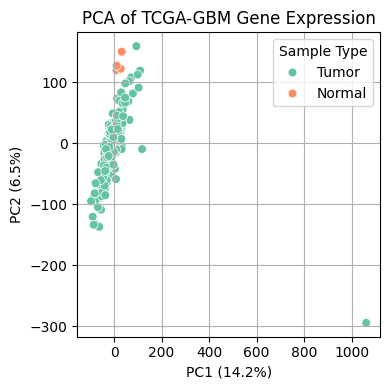

In [44]:
gbm_df_pca = plot_pca(exp_df_scaled=gbm_exp_df_scaled, clinical_df=gbm_clinical_df, exp_df_t=gbm_exp_df, cancer_type="TCGA-GBM")

### There is one outlier in GBM PCA plot, let's remove it
### Use Z-score method to remove outlier

In [23]:
from scipy.stats import zscore

In [47]:
def get_outlier_samples(df_pca:pd.DataFrame, threshold=3):
    """Identify outlier samples using z-score cutoff of 3 standard deviations above mean distance"""
    # get mean position (centroid) across all samples in PCA space
    center = np.mean(df_pca[['PC1', 'PC2']], axis=0)
    # subtract center from each sample and calculate euclidean norm
    distances = np.linalg.norm(df_pca[['PC1', 'PC2']] - center, axis=1)
    z_scores = zscore(distances)
    outlier_indices = np.where(z_scores > threshold)[0]
    
    return outlier_indices    

In [48]:
gbm_outlier_sample = gbm_df_pca['sample_id'][get_outlier_samples(gbm_df_pca)].values

In [46]:
# remove outlier samples and create PCA dataframe again
gbm_exp_df = gbm_exp_df.drop(gbm_outlier_sample, axis=1)
gbm_clinical_df = gbm_clinical_df[~gbm_clinical_df['sample_id'].isin(gbm_outlier_sample)]

gbm_exp_df_scaled, gbm_clinical_df = prepare_for_pca(gbm_exp_df, gbm_clinical_df)


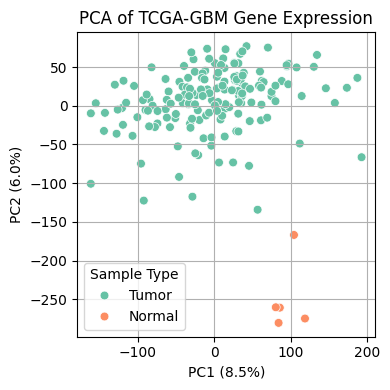

In [50]:
_ = plot_pca(exp_df_scaled=gbm_exp_df_scaled, clinical_df=gbm_clinical_df, exp_df_t=gbm_exp_df, cancer_type="TCGA-GBM")

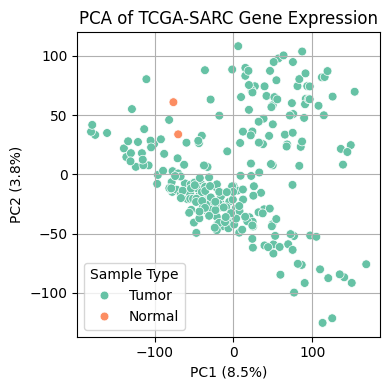

,PC1,PC2,sample_id,tissue_type.samples
0,107.958460,57.917274,TCGA-DX-A48J-01A,Tumor
1,22.505805,-1.312464,TCGA-QQ-A5VA-01A,Tumor
2,-25.596012,-31.823866,TCGA-DX-AB36-01A,Tumor
3,-77.640347,-14.786712,TCGA-Z4-AAPG-01A,Tumor
4,38.896628,-29.467832,TCGA-DX-A8BU-01A,Tumor
...,...,...,...,...
260,-22.947012,-23.096523,TCGA-DX-AB2P-01A,Tumor
261,-73.959214,-1.442576,TCGA-DX-A6BE-01A,Tumor
262,67.458108,23.503672,TCGA-HS-A5NA-01A,Tumor
263,24.001497,-43.121979,TCGA-DX-AB2J-01A,Tumor


In [ ]:
# plot PCA for SARC
_ = plot_pca(exp_df_scaled=sarc_exp_df_scaled, clinical_df=sarc_clinical_df, exp_df_t=sarc_exp_df, cancer_type="TCGA-SARC")

In [ ]:
# plot 2 cancer types together


Look for subtle subtypes, presenting small clusters (use UMAP/t-SNE)